# Webscraping To Make Pokemon Flash Cards
***


Recently, I put a bit of effort into making a number of flash cards on an amazing open source flashcard app called **Anki**. I wanted to memorize the type effectiveness of the various types of Pokemon, and I made a nice deck for myself to study! Unfortunately, I went to study today and found that my cards were gone! :(

> EDIT: Turns out I never synced/uploaded them from my AnkiDroid mobile version of the app... But! I still want to automate this mf

### Enter: Frustration

This pain reignited in me a passion to develop a time-saving, and automated solution for producing flash cards.

### Enter: `genanki`

`genanki` is a Python3 library that allows you to programmatically generate flashcards for the Anki flashcard software. We will see how to use this shortly, but ultimately, we are left with the necessary `.apkg` file(s) required to create our decks.


## The Plan:

*  Gather Data using `requests` and beautiful soup, `bs4`, to pull tables/data
*  Get it nice and parsed using ... pandas? Idk, up to me, let's pull the request first
*  Use `genanki` to write cards from the organized data.
*  Tbh -- idk what that entails yet, just know that I really want to make flash cards, so let's get started


In [1]:
import requests
import bs4

# pull the http request, then get the text
source = requests.get('https://www.polygon.com/pokemon-go-guide/2020/2/4/21121160/type-strength-weakness-super-effective-weakness-chart').text

At this point, `source` is in a text format and looks like an HTML file. We want to run this through beautiful soup

In [2]:
soup = bs4.BeautifulSoup(source, 'html.parser')

# print(soup.prettify())
#
#
# Outputs:
#
# <!DOCTYPE html>
# <html lang="en">
#  <head>
#   <title>
#    Pokémon Go type strength and weakness chart  - Polygon
#   </title>
#   <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
#   <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
#   <meta content="width=device-width, initial-scale=1, shrink-to-fit=no" name="viewport"/>
#   <meta content="Polygon" name="apple-mobile-web-app-title">
#    <script src="https://optimize-stats.voxmedia.com/loader.min.js?key=6e06b9766c08ed8f" type="text/javascript">
#    </script>
#    <meta content="Julia Lee" property="author">
#     <meta content="2020-02-04T11:14:08-05:00" property="article:published_time">
#
#
#    .
#    .
#    .
 

Now we can run some cool soup methods on this soupy object. In particular, we are going to find the element we're interested in.

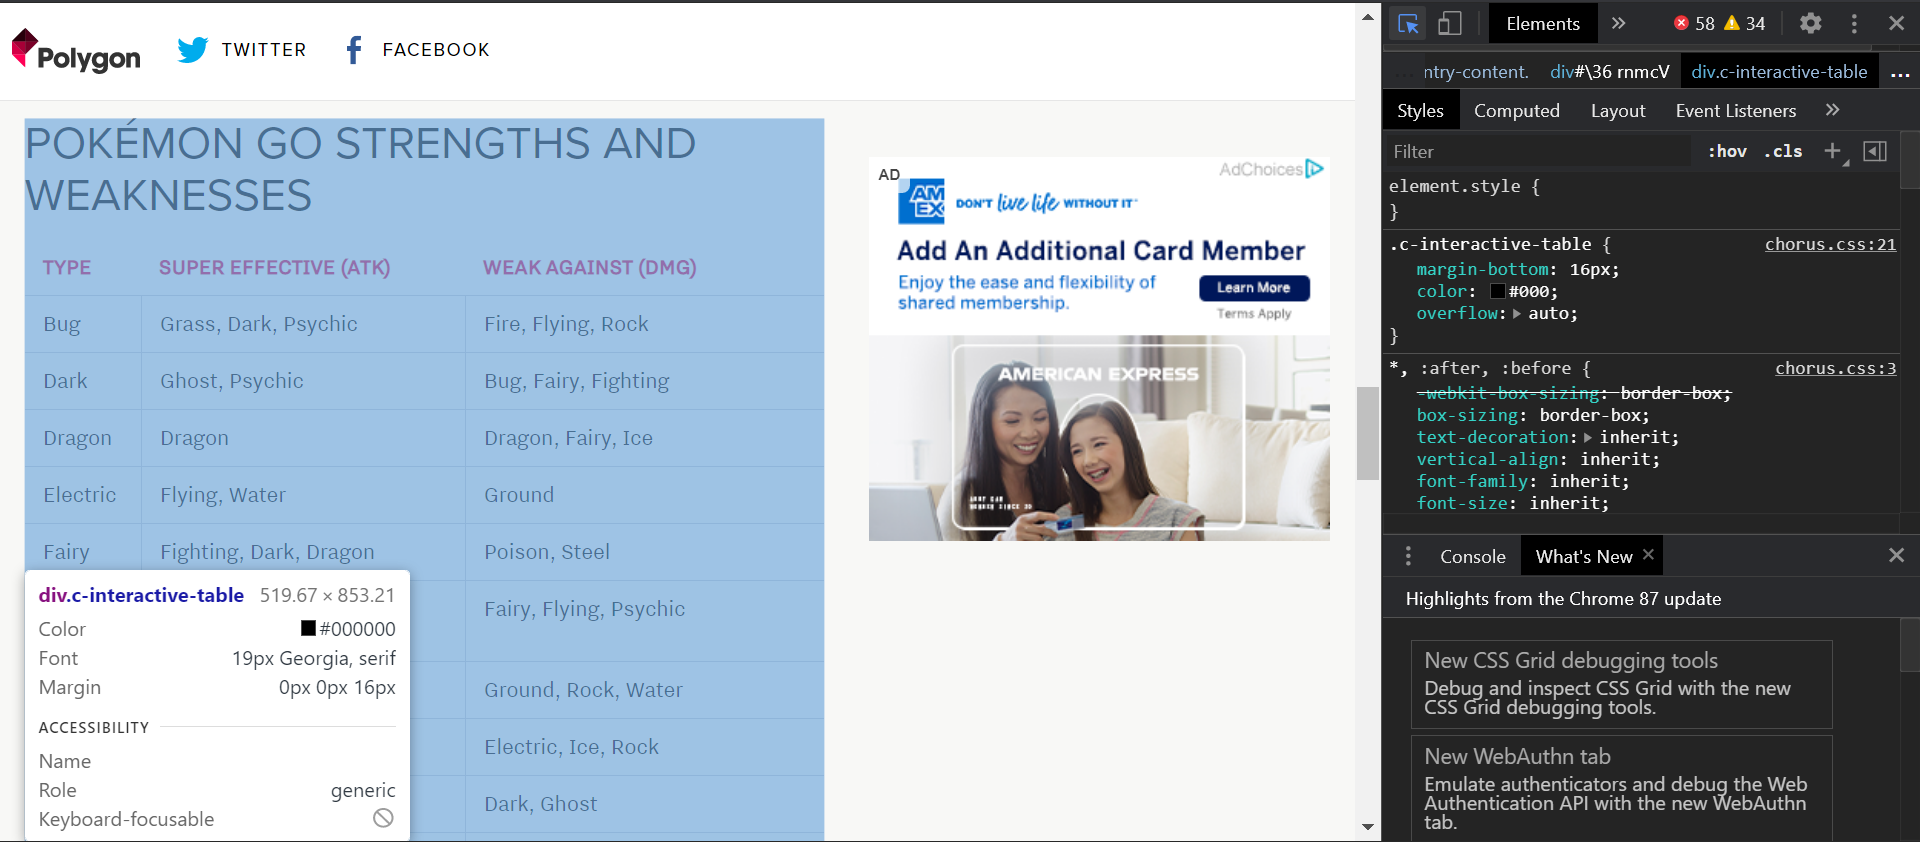

We need to run the `find` method to retrieve that weird div classed element: `div.c-interactive-table`.

In [3]:
table = soup.find(class_='c-interactive-table')

# print(table)

# Prints:
# 
#
# <div class="c-interactive-table" data-cdata='{"paging":false,"searchable":false,"sort_column":0,"sort_descending":false,"sortable":false}' data-cid="apps/interactive_table-1611474783_334_72409">
# <h3>Pokémon Go Strengths and Weaknesses</h3>
# <table class="p-data-table" width="100%">
# <thead>
# <tr>
# <th>TYPE</th>
# <th>SUPER EFFECTIVE (ATK)</th>
# <th>WEAK AGAINST (DMG)</th>
# </tr>
# </thead>
# <tfoot>
# <tr>
# <th>TYPE</th>
# <th>SUPER EFFECTIVE (ATK)</th>
# <th>WEAK AGAINST (DMG)</th>
# </tr>
# </tfoot>
# <tbody>
# <tr>
# <td>Bug</td>
# <td>Grass, Dark, Psychic</td>
# <td>Fire, Flying, Rock</td>
# </tr>
# <tr>
# <td>Dark</td>
# <td>Ghost, Psychic</td>
# <td>Bug, Fairy, Fighting</td>
# </tr>
# <tr>
# <td>Dragon</td>
# <td>Dragon</td>
# <td>Dragon, Fairy, Ice</td>
# </tr>
# <tr>
# <td>Electric</td>
# <td>Flying, Water</td>
#   .
#   .
#   .




>Okay, so like, wow. After switching to Microsoft Edge I seem to not be running into an important issue I had before, namely, the browser wasn't compiling the table! But it seems to be doing it now, so I will be creating a branch from here that uses Edge. Perhaps, I will try to run Selenium with chrome another time. But for now, I'm stoked that this works!

In [4]:
# Notice that all the elements of the table are 'td' tags. We can pull these.
# I'd guess that they'd be... Strings?
# Or, an array of strings, in find_all

mems = table.find_all('td')

# print(mems)

# [<td>Bug</td>, <td>Grass, Dark, Psychic</td>, <td>Fire, Flying, Rock</td>, <td>Dark</td>,
# <td>Ghost, Psychic</td>, <td>Bug, Fairy, Fi...]


# no need to guess the type

# print(type(mems[0]))
#
# Prints:
# <class 'bs4.element.Tag'>


# print(type(mems[0].text))
#
# Prints:
# <class 'str'>

### Success!

This is going to be easier than I thought!

Recall the format of the table: it is in 3 columns. From left to right, they are

1. Type
2. Super Effective Against
3. Weak Against

We will check that the elements indeed appear in multiples of 3, as a pseud0-safeguard to ensuring our table is being completed.

In [5]:
len(mems)

54

Indeed, 3 times.... Something. But before we forget, best that we get rid of the tags, or extract the text from within them!

We also may need to 'box' the contents of some of the td's because some of them are 'lists' of types, e.g. 'flying, water' are in "strong against" as a pair, since electric is strong against 'flying, water'

Okay! So, let's separate it into proper 'columns....'

In [6]:
# This just gets rid of spaces for easier parsing, and also splits the
# subitems in the array by commas:

# This is important for providing a *list* of types that are "effective
# against" or "vulnerable to," as opposed to a string containing all the types

mems = [subitem.replace(' ','').split(',') for item in mems for subitem in item]

# print(mems)

# do you notice anything odd about/in the array?
# I can think of two... We'll try to remember to
# address those points later

In [7]:
# Basically grab every third element 
# from different starting points

# Have to unpack/flatten type_of with another pythonism
type_of = [subthing for thing in mems[0::3] for subthing in thing]

# This grabs the 2nd element and slices through every third after
strong_against = mems[1::3]
# This grabs the 3rd element and slices through every third after
weak_against = mems[2::3]


# print(type_of)
#
# Prints:
# ['Bug','Dark', ....]

# print(strong_against)
#
# Prints:
# [['Grass','Dark','Psychic'],['Ghost','Psychic'],...]

# print(weak_against)
#
# Prints:
# [['Grass','Dark','Psychic'],['Ghost','Psychic'],...]


### Some fun PokeLogic

We need to perform some logic to pull who is "vulnerable to" and "resistant to" from this.
Let X be a Pokemon type. We know that if X "is strong against" type(s) Y, then type(s) Y are "vulnerable to" type X. This is basically describing the inverse mapping from the target of "strong against" back to the domain of our original types.


In [8]:
ind = type_of
stronk = strong_against
weak = weak_against
vulnerable_to = []
resistant_to = []

n = len(ind)

# Pretty much an iterative inverse mapping. Checks
# all elements of target, maps back with set logic
    
for i in range(n):
    vuls = set()
    res = set()
    
    for j in range(n):
        if ind[i] in stronk[j]:
            vuls.add(ind[j])
        if ind[i] in weak[j]:
            res.add(ind[j])
    vulnerable_to.append(vuls)
    resistant_to.append(res)
    
# print(vulns)
# print(resists)

# Genanki

Alright, so it's time to get to the bread and butter of this gosh fangled pokemon quiz, `genanki`.

`genanki` is a pretty cool, succinct [package](href=https://github.com/kerrickstaley/genanki), graciously maintained by GitHub user kerrickstanley.

***

### Installing


> It might be helpful to run <code>python -m pip install --upgrade pip</code> to upgrade pip first.

If you are running an .ipynb on an Anaconda interpreter, as I am, then you must install `genanki` through the anaconda prompt, and type:
<br><br>
<center><code>pip install genanki</code> </center>
<br>
If you are on a separate environment, like your Windows installation, running from c:/python... or c:/programs... then you should install from your command prompt, using the same commmand.

If you are using PyCharm or some other cool editor and have your environments sorted out, good for you, so happy for you. Install away.

---

#### All done! :)

Now we are going to import it and make some cards.

Before getting started, I can't reccomend enough reading the README.md at the repo page, https://github.com/kerrickstaley/genanki/blob/master/README.md


## Genanki .Model()

If you know ANKI, you know that there are different card styles, and different inputs. Some allow for images, sounds, etc. ANKI is very neat. The different `fields` are defined here, and some other things.

In [9]:
import genanki

style = """
.card {
 font-family: times;
 font-size: 30px;
 text-align: center;
 color: black;
 background-color: white;
}

.card1 { background-color:bisque }
"""

PokeModel = genanki.Model(
    1234567890,             # this is a unique ID for the model, hardcode it from a random int      
    'PokeModel',            # This is the str name for the model, I think..
    fields=[
        {'name':'Type Effectiveness'},   # One field on the card: similar to extra image, sound etc.
        {'name':'Affected Types'}        # 
        
    ],
    templates=[
        {
            'name': 'Card 1',
            'qfmt': '{{Type Effectiveness}}',                            # Question format
            'afmt': '{{FrontSide}}<hr id="answer">{{Affected Types}}'     # Answer format
        }
    ],
    css= style
)

## Next step: Making `Note()`s

`Note()` objects *are* the ANKI flashcards. They contain the information that goes into the fields specified for the `model` that we just created, namely `PokeModel`.

Here is how you would make a single note:

```python
import genanki

type_of = 'bug'
eff_ag = 'flying and grass and psychic brooo''

my_first_note = genanki.Note(
    model=PokeModel,
    fields=[f'{type_of}', f'absolutely wrecks {eff_ag}']
)
```


In [10]:
n = len(type_of)
notes = []
for i in range(n):
    notes.append(
        genanki.Note(
        model=PokeModel,
            fields=[f'{type_of[i]} is strong against ', f' {strong_against[i]}']
        )
    )
    notes.append(
        genanki.Note(
            model=PokeModel,
            fields=[f'{type_of[i]} is weak against', f'{weak_against[i]}']
        )
    )
    notes.append(genanki.Note(
        model=PokeModel,
        fields=[f'{type_of[i]} is vulnerable to ', f'{vulnerable_to[i]}']
    ))
    notes.append(genanki.Note(
        model=PokeModel,
        fields=[f'{type_of[i]} is resistant to ', f'{resistant_to[i]}']
    ))
# print(notes)

Now we create a deck, and add the notes to the deck. Then we package them and write this package to a file. We need to make a quick random int to set for the deck_id

```python
import random; random.randrange(1<<30,1<<31)
```
returns `2128525735`'

> for those wondering what's happening, that `<<` is a shift operator:
> it moves the bit "`1`" over  by 30 places in binary, from 2^0
> to 2^30, or `1_073_741_824`. This number is about 10 digits, and 2^31 would
> be `2_140_000_000`, so we'd have a large random pool of integers to hard code from

In [11]:
# import random; print(random.randrange(1<<30,1<<31))

In [12]:
poke_deck = genanki.Deck(
    2128525735,
    'Pokemon Type Effectiveness'
)

Now we need to add the notes to the deck,

In [13]:
for note in notes:
    poke_deck.add_note(note)

And lastly, we need to package them and output them to a file

In [14]:
genanki.Package(poke_deck).write_to_file('POKEMON.apkg')

I can now see my `POKEMON.apkg` file in the folder where this notebook is kept.

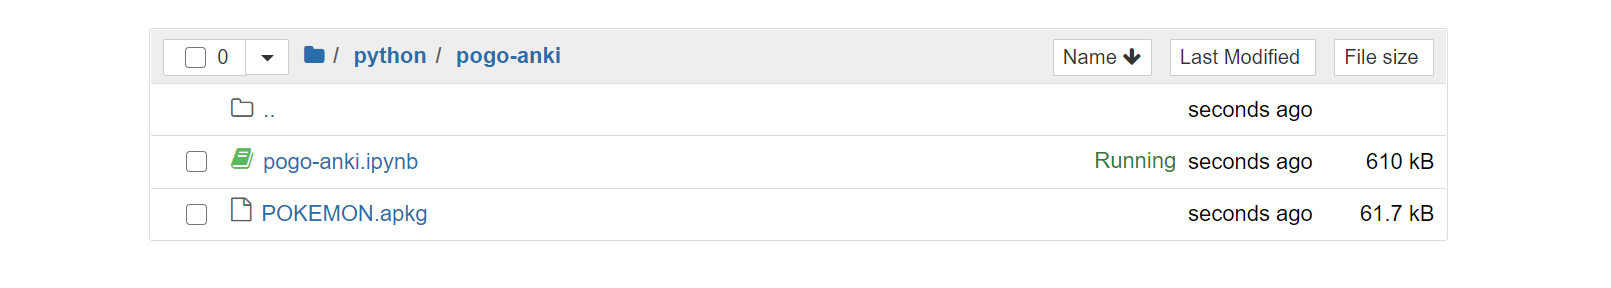

I'm excited! Let's see how this looks!

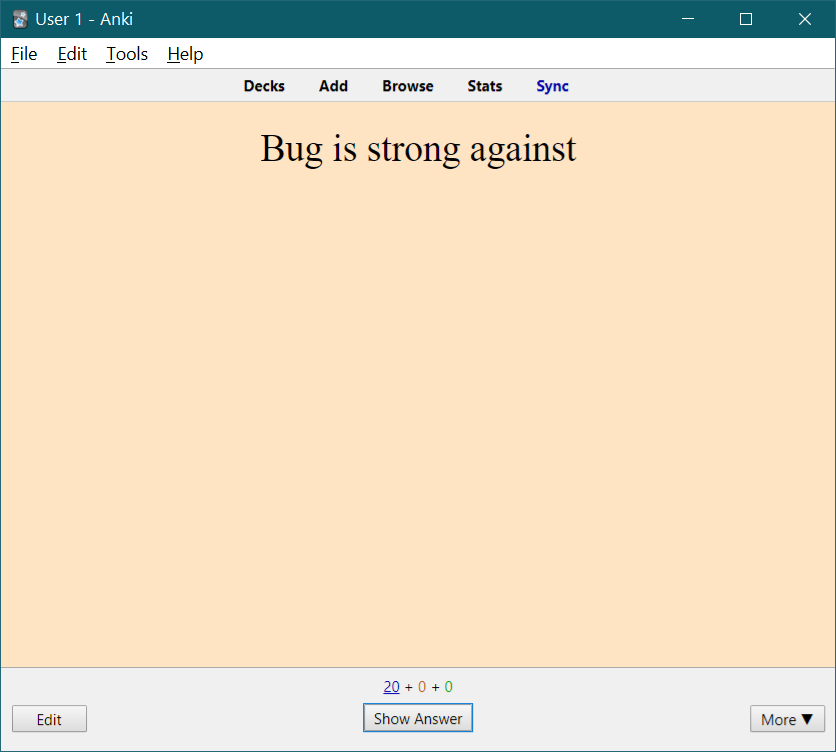
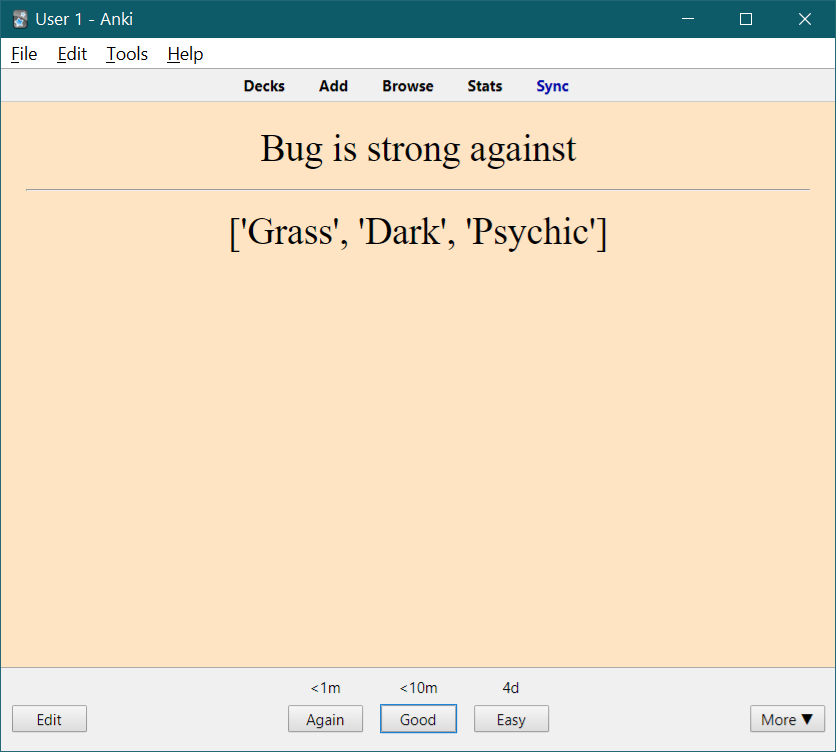

As you can see! It works!

Another goal is to add the pokemon type symbols and link them to the names, so that it isn't just 'dark', and instead shows a symbol/.png. Also, I would much like to get rid of the array styled answers, and dict styled answers, which was necessary for the inverse mapping to get 'vulnerable to' and 'resistant to' types.